# Dataset Generation

Generate the initial dataset.

Store items from 5 classes into memory

In [1]:
import glob
import os.path as path

import ndjson

dataset_path='/raid5/liuchang/quick_draw'
class_name = ['calendar', 'snowman', 'penguin', 'blackberry', 'teddy-bear']  # class_name=-1 means all class
country_code = -1  # country_code=-1 means all countries
output_path='/raid5/liuchang/quick_draw_output'


import numpy as np
def split_data(data):
    return [(i['recognized'],i['drawing'],i['word']) for i in data]

splitted=[]
i =0
min_len=np.inf
for file_path in glob.iglob(path.join(dataset_path,'*.ndjson')):
    i += 1
    label=file_path.split('/')[-1].split('.')[0]
    if class_name!=-1 and label not in class_name:
        continue
    print('readding data from {}'.format(file_path))
    with open(file_path) as f:
        data = ndjson.load(f)
    print('Now found {} avaliable data.'.format(len(data)))
    splitted.append(split_data(data))
    min_len=min(min_len,len(data))

readding data from /raid5/liuchang/quick_draw/penguin.ndjson
Now found 253791 avaliable data.
readding data from /raid5/liuchang/quick_draw/teddy-bear.ndjson
Now found 179568 avaliable data.
readding data from /raid5/liuchang/quick_draw/calendar.ndjson
Now found 321981 avaliable data.
readding data from /raid5/liuchang/quick_draw/snowman.ndjson
Now found 340029 avaliable data.
readding data from /raid5/liuchang/quick_draw/blackberry.ndjson
Now found 128153 avaliable data.


## Balance the data

In [ ]:
import random
dataset=[]
for i,data in enumerate(splitted):
    dataset+=random.sample(data,min_len)

## Remove too large paint
First we check the maximal length of strokes and the number of strokes, and remove the paints which have too much strokes or too long strokes

In [2]:
def get_max_len_stroke(x):
    l_len=[]
    l_stroke=[]
    for i,item in enumerate(x):
        item=item[1]
        l_stroke.append(len(item))
        max_len=0
        for j,stroke in enumerate(item):
            max_len=max(max_len,len(stroke[0])) 
        l_len.append(max_len)
    return l_len,l_stroke
l_len,l_strock=get_max_len_stroke(dataset)

In [3]:
def count(l):
    x=list(range(0,max(l)))
    y=[l.count(i) for i in x]
    return x,y

In [5]:
max_stroke_cut=30
to_cut=np.sum(y[max_stroke_cut:])

The histogram of the number of stroke in one paint. As we can see most of the number are smaller but there are some extreme cases.

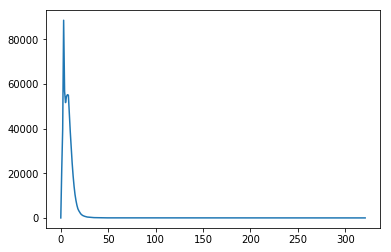

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
x,y=count(l_strock)
plt.figure()
plt.plot(x,y)
plt.show()

In [7]:
max_len_cut=200
to_cut+=np.sum(y[max_len_cut:])

The histogram of the maximal stroke of stroke in one paint. As we can see most of the number are smaller but there are some extreme cases.

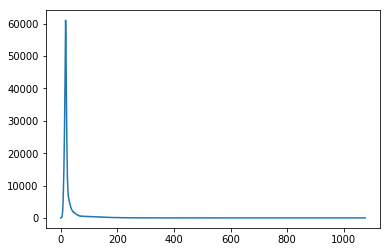

In [6]:
x,y=count(l_len)
plt.figure()
plt.plot(x,y)
plt.show()

By remove paints which have more than 30 strokes or have stroke longer than 200, we can reduce the memory usage (if the model requires padding), but just lost about 1% data 

In [8]:
print("To cut",to_cut,"paintings")
print("It is about",to_cut/(len(dataset)))

To cut 7941 paintings
It is about 0.012392998993390712


In [87]:
#cut down dataset
def cut_large_paint(x,max_stroke_cut,max_len_cut):
    new_dataset=[]
    for i,item in enumerate(x):
        item=item[1]
        if len(item)>max_stroke_cut:
            continue
        max_len=0
        for j,stroke in enumerate(item):
            max_len=max(max_len,len(stroke[0])) 
        if max_len>max_len_cut:
            continue
        new_dataset.append(x[i])
    return new_dataset
new_dataset=cut_large_paint(dataset,max_stroke_cut,max_len_cut)

In [92]:
dataset=new_dataset

## Shuffle & Save
Shuffle the data, and split the data.

In [93]:
random.shuffle(dataset)
print(min_len,len(dataset))
Recognized=[i[0] for i in dataset]
X=[i[1] for i in dataset]
Y=[i[2] for i in dataset]

Yu = set(Y)
dict = {}
for index, label in enumerate(Yu):
    dict[label] = index

Yc = []
for i in Y:
    Yc.append(dict[i])

r=int(0.8*len(X))
train_Recognized=Recognized[:r]
train_X=X[:r]
train_Y=Yc[:r]
test_Recognized=Recognized[r:]
test_X=X[r:]
test_Y=Yc[r:]

128153 633244


In [94]:
import pickle
import os
with open(os.path.join(output_path,'1102_05b'+str(len(X))),'wb') as f:
    pickle.dump((train_Recognized,train_X,train_Y,test_Recognized,test_X,test_Y),f)

In [95]:
len(train_X)+len(test_X)

633244